# Packages and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
df = pd.read_csv("C:/Users/chole/Desktop/Personal_medical_cost/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data split

In [4]:
X = df.drop(columns=["charges"])
y = df.charges

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=X[["smoker"]])

In [6]:
f"Shapes of X_train={X_train.shape}, X_test={X_test.shape}, y_tain={y_train.shape}, y_test={y_test.shape}"

'Shapes of X_train=(1070, 6), X_test=(268, 6), y_tain=(1070,), y_test=(268,)'

# Column transformation

In [7]:
column_t = make_column_transformer(
    # add OHE only for 3 columns, drop lvl only for binary variable (sex, smoker)
    (OneHotEncoder(drop="if_binary"), ["sex", "region", "smoker"]), 
    # add Standard Scaler only on quantitative variables
    (StandardScaler(), ["age", "bmi", "children"]),
    remainder="passthrough"
)

# Selecting the best model

LR: 0.725405 (0.061729)
Lasso: 0.725407 (0.061713)
KNN: 0.629534 (0.075079)
Bayesian: 0.725428 (0.061522)


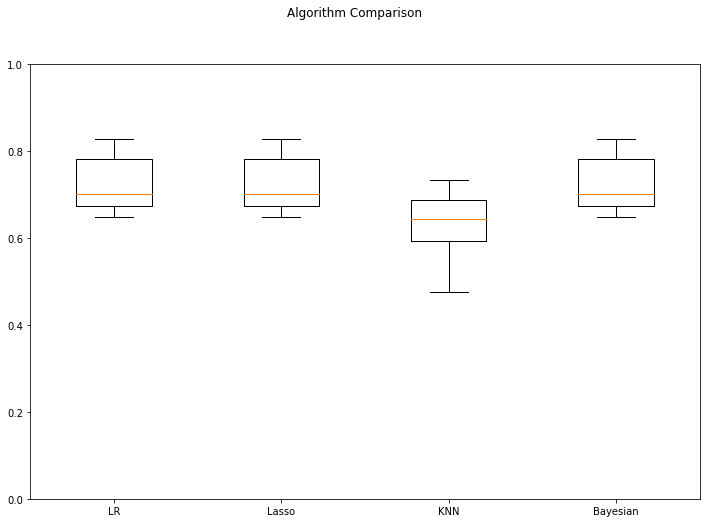

In [8]:
names=[]
results =[] # for all results
score_fp = [] # for mean of r2

models={'LR': LinearRegression(),
       'Lasso': Lasso(),
       'KNN': KNeighborsRegressor(),
       'Bayesian': BayesianRidge()

}

for name, model in models.items(): # need .items() cause dictionary above

    pipe = Pipeline([
        ("preProc", column_t),
        ("model", model)
    ]) # pipeline with preprocessing of the data and model

    cv_res = cross_val_score(pipe, X_train, y_train, cv=10, scoring='r2') # cross-validation

    results.append(cv_res) # add results to the list
    names.append(name) # add name of algorithm to the list
    score_fp.append(cv_res.mean()) # add mean of R^2 to the list
    print("%s: %f (%f)" % (name, cv_res.mean(), cv_res.std())) # print nice list with mean and std
    
# boxplot algorithm comparison 
# Source: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111) # all on the same box
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylim(0,1)
plt.show()

In [9]:
dane = {
    "Names": names,
    "Score R^2": score_fp
}

pd.DataFrame(dane).max() 

Names           Lasso
Score R^2    0.725428
dtype: object

# Building the final model

cross_val_score: 0.7557 


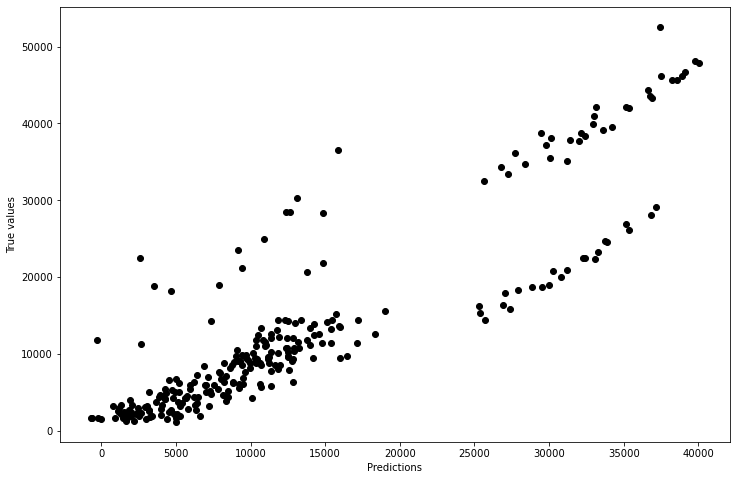

In [10]:
pipe = Pipeline([
        ("preProc", column_t),
        ("model", Lasso())
    ])

model_final = pipe.fit(X_train, y_train)
pred = model_final.predict(X_test)

plt.scatter(x=pred, y=y_test, color="black")
plt.xlabel("Predictions")
plt.ylabel("True values")

print("%s: %.4f " % ("cross_val_score", cross_val_score(pipe, X_test, y_test).mean()) )

Text(0.5, 1.0, 'Normal Q-Q Plot')

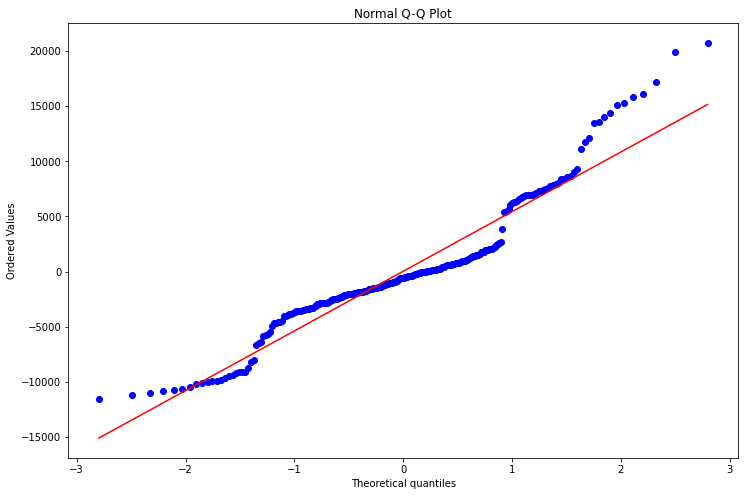

In [11]:
residuals = y_test - pred.reshape(-1)
probplot(residuals, dist='norm', plot=plt)
plt.title("Normal Q-Q Plot")

**Model score 75.57%** <br />
The Q-Q Plot suggests deviations of the residuals from the normal distribution.

# Removing outliers

Since there were outliers in the data we will remove them and see how the model result changes.

In [12]:
def remove_outliers(df_in):

    Q1 = df_in.quantile(0.25)
    Q3 = df_in.quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5*IQR
    lower_limit = Q1 - 1.5*IQR

    df_clean = df_in[~((df_in < lower_limit) | (df_in > upper_limit)).any(axis=1)]
    
    return df_clean

In [13]:
df_clean = remove_outliers(df.loc[:,["age", "bmi", "charges"]])

for i in range(10):
    df_clean = remove_outliers(df_clean)

print("Number of cases in df:", len(df))
print("Number of cases in df_clean:", len(df_clean))
print("We've removed:", round(100-(len(df_clean)*100/len(df)),2), "percent of rows.")

df_trimmed = df[df.index.isin(df_clean.index)]

Number of cases in df: 1338
Number of cases in df_clean: 1105
We've removed: 17.41 percent of rows.


In [14]:
X = df_trimmed.drop(columns=["charges"])
y = df_trimmed.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=X[["smoker"]])

LR: 0.650658 (0.092545)
Lasso: 0.650654 (0.092529)
KNN: 0.430952 (0.081546)
Bayesian: 0.650642 (0.092181)


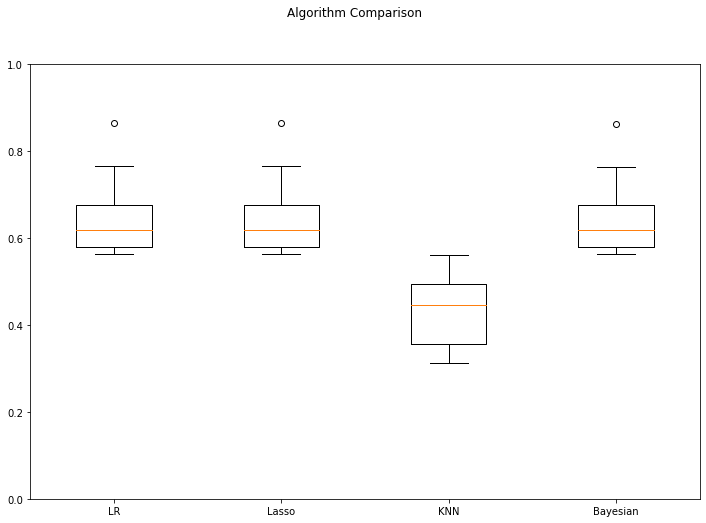

In [15]:
names=[]
results =[] # for all results
score_fp = [] # for mean of r2

models={'LR': LinearRegression(),
       'Lasso': Lasso(),
       'KNN': KNeighborsRegressor(),
       'Bayesian': BayesianRidge()

}

for name, model in models.items(): # need .items() cause dictionary above

    pipe = Pipeline([
        ("preProc", column_t),
        ("model", model)
    ]) # pipeline with preprocessing of the data and model

    cv_res = cross_val_score(pipe, X_train, y_train, cv=10, scoring='r2') # cross-validation    

    results.append(cv_res) # add results to the list
    names.append(name) # add name of algorithm to the list
    score_fp.append(cv_res.mean()) # add mean of r2 to the list
    print("%s: %f (%f)" % (name, cv_res.mean(), cv_res.std())) # print nice list with mean and std

# boxplot algorithm comparison 
# Source: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111) # all on the same box
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylim(0,1)
plt.show()

In [16]:
dane = {
    "Names": names,
    "Score R^2": score_fp
}

pd.DataFrame(dane).max()  

Names           Lasso
Score R^2    0.650658
dtype: object

cross_val_score: 0.8488 


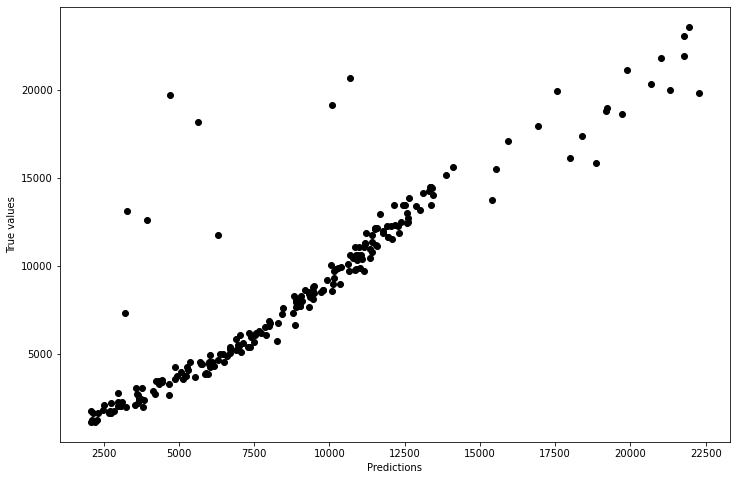

In [17]:
pipe = Pipeline([
        ("preProc", column_t),
        ("model", Lasso())
    ])

model_final = pipe.fit(X_train, y_train)
pred = model_final.predict(X_test)

plt.scatter(x=pred, y=y_test, color="black")
plt.xlabel("Predictions")
plt.ylabel("True values")

print("%s: %.4f " % ("cross_val_score", cross_val_score(pipe, X_test, y_test).mean()) )

Text(0.5, 1.0, 'Normal Q-Q Plot')

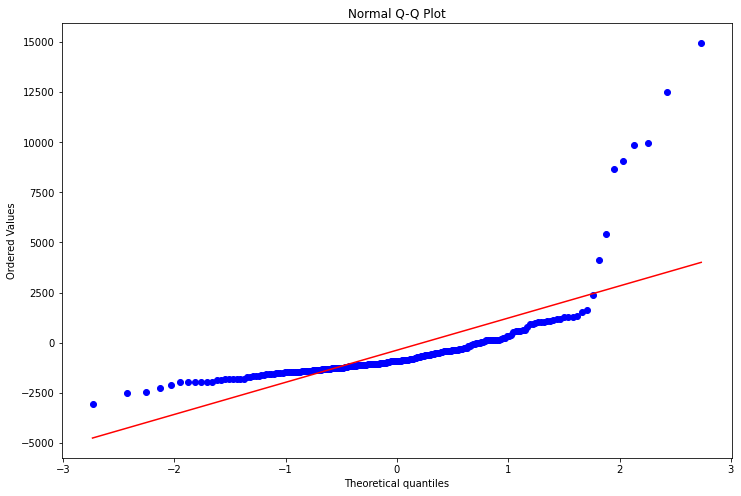

In [18]:
residuals = y_test - pred.reshape(-1)
probplot(residuals, dist='norm', plot=plt)
plt.title("Normal Q-Q Plot")

**Model score: 84.88%** <br />
The Q-Q Plot shows significant deviations from the normal distribution at high values.

Text(0, 0.5, 'True values')

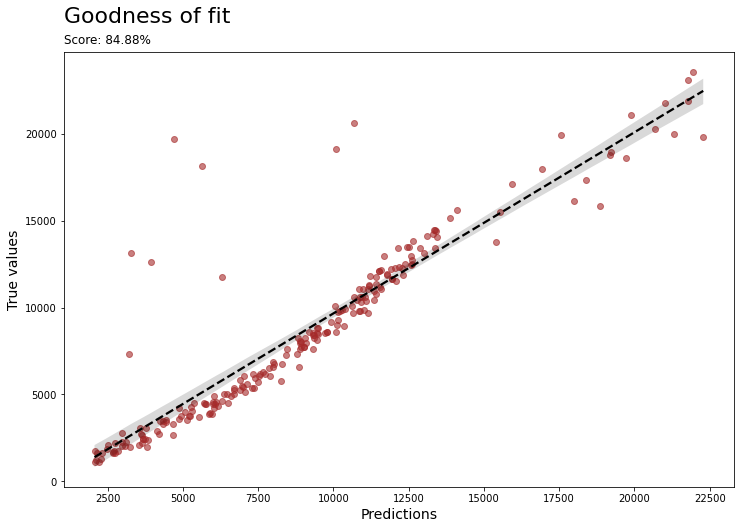

In [21]:
# A better graph for the final model ~ with regression line 
sns.regplot(x=pred, y=y_test, color="black", scatter=True,
    scatter_kws = {'color': 'brown', 'alpha': 0.6}, line_kws = {'color': 'black', 'linestyle':'dashed'})

   
plt.title("Goodness of fit \n", size = 22, loc='left')
plt.suptitle(t="Score: "+str(np.round(cross_val_score(pipe, X_test, y_test).mean(),4)*100)+"%", ha='left', x=0.125, y = 0.912)
plt.xlabel("Predictions", fontsize=14)
plt.ylabel("True values", fontsize=14)